# Human Activity Recognition with LSTM using Motion Sensor Data

# Importing

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

In [51]:
user1_df = pd.read_csv("user1_presence_data_60.csv")
user2_df = pd.read_csv("user2_presence_data_60.csv")

In [53]:
# Convert 'time' column to datetime
user1_df["time"] = pd.to_datetime(user1_df["time"])
user2_df["time"] = pd.to_datetime(user2_df["time"])

In [55]:
# Merge datasets directly by time to ensure each row contains both users' states
merged_df = pd.merge(user1_df, user2_df, on="time", suffixes=("_user1", "_user2"))

# Feature Engineering

In [58]:
# Extract hour, minute, day
merged_df["hour"] = merged_df["time"].dt.hour
merged_df["minute"] = merged_df["time"].dt.minute
merged_df["day_of_week"] = merged_df["time"].dt.dayofweek  # Monday=0 ... Sunday=6
merged_df["is_weekend"] = merged_df["day_of_week"].isin([5,6]).astype(int)

In [60]:
merged_df

,time,state_user1,state_user2,hour,minute,day_of_week,is_weekend
0,2022-04-24 00:01:00+00:00,living room,living room,0,1,6,1
1,2022-04-24 00:01:30+00:00,living room,living room,0,1,6,1
2,2022-04-24 00:02:00+00:00,living room,living room,0,2,6,1
3,2022-04-24 00:02:30+00:00,living room,living room,0,2,6,1
4,2022-04-24 00:03:00+00:00,living room,living room,0,3,6,1
...,...,...,...,...,...,...,...
172793,2022-06-22 23:57:30+00:00,bedroom,bedroom,23,57,2,0
172794,2022-06-22 23:58:00+00:00,bedroom,bedroom,23,58,2,0
172795,2022-06-22 23:58:30+00:00,bedroom,bedroom,23,58,2,0
172796,2022-06-22 23:59:00+00:00,bedroom,bedroom,23,59,2,0


## Model Preprocessing

In [63]:
# Label-encode states
le_state_user1 = LabelEncoder()
le_state_user2 = LabelEncoder()

merged_df["state_user1"] = le_state_user1.fit_transform(merged_df["state_user1"])
merged_df["state_user2"] = le_state_user2.fit_transform(merged_df["state_user2"])

# Save encoders for later
with open("le_state_user1.pkl","wb") as f:
    pickle.dump(le_state_user1, f)
with open("le_state_user2.pkl","wb") as f:
    pickle.dump(le_state_user2, f)

In [65]:
# Cyclical features
merged_df["hour_sin"] = np.sin(2*np.pi*merged_df["hour"]/24)
merged_df["hour_cos"] = np.cos(2*np.pi*merged_df["hour"]/24)

merged_df["minute_sin"] = np.sin(2*np.pi*merged_df["minute"]/60)
merged_df["minute_cos"] = np.cos(2*np.pi*merged_df["minute"]/60)

merged_df["day_sin"] = np.sin(2*np.pi*merged_df["day_of_week"]/7)
merged_df["day_cos"] = np.cos(2*np.pi*merged_df["day_of_week"]/7)

In [67]:
# Drop columns not needed
merged_df.drop(columns=["time","hour","minute","day_of_week"], inplace=True)

In [69]:
merged_df

,state_user1,state_user2,is_weekend,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos
0,3,3,1,0.000000,1.000000,0.104528,0.994522,-0.781831,0.623490
1,3,3,1,0.000000,1.000000,0.104528,0.994522,-0.781831,0.623490
2,3,3,1,0.000000,1.000000,0.207912,0.978148,-0.781831,0.623490
3,3,3,1,0.000000,1.000000,0.207912,0.978148,-0.781831,0.623490
4,3,3,1,0.000000,1.000000,0.309017,0.951057,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...
172793,0,0,0,-0.258819,0.965926,-0.309017,0.951057,0.974928,-0.222521
172794,0,0,0,-0.258819,0.965926,-0.207912,0.978148,0.974928,-0.222521
172795,0,0,0,-0.258819,0.965926,-0.207912,0.978148,0.974928,-0.222521
172796,0,0,0,-0.258819,0.965926,-0.104528,0.994522,0.974928,-0.222521


# Reshaping

In [72]:
num_states_user1 = len(le_state_user1.classes_)
num_states_user2 = len(le_state_user2.classes_)

In [74]:
# Suppose 24hr -> 30s intervals => 24*60*2 = 2880 time steps
time_steps = 2880

# Separate features vs states
features = merged_df.drop(columns=["state_user1","state_user2"]).values
user1_states = merged_df["state_user1"].values
user2_states = merged_df["state_user2"].values

# Keep only multiples of time_steps
num_samples = (len(features)//time_steps)*time_steps
features = features[:num_samples]
user1_states = user1_states[:num_samples]
user2_states = user2_states[:num_samples]

batch_size = num_samples//time_steps

In [76]:
# Reshape to (batch_size, time_steps, num_features)
X = features.reshape(batch_size, time_steps, features.shape[1])
y1 = user1_states.reshape(batch_size, time_steps, 1)
y2 = user2_states.reshape(batch_size, time_steps, 1)

In [78]:
print("X.shape =", X.shape, "y1.shape =", y1.shape, "y2.shape =", y2.shape)

X.shape = (59, 2880, 7) y1.shape = (59, 2880, 1) y2.shape = (59, 2880, 1)


# Building the LSTM Model

In [81]:
def create_lstm_model(input_shape, num_states_user1, num_states_user2):
    inputs = Input(shape=input_shape)

    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output for user1
    out_user1 = Dense(num_states_user1, activation="softmax", name="state_user1")(x)
    # Output for user2
    out_user2 = Dense(num_states_user2, activation="softmax", name="state_user2")(x)

    model = Model(inputs=inputs, outputs=[out_user1, out_user2])

    # Provide a separate metric for each output
    model.compile(
        loss=["sparse_categorical_crossentropy","sparse_categorical_crossentropy"],
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[["accuracy"], ["accuracy"]]
    )
    return model

In [83]:
num_states_user1 = len(le_state_user1.classes_)
num_states_user2 = len(le_state_user2.classes_)

# Model Training

In [86]:
tscv = TimeSeriesSplit(n_splits=5)

user1_reports = []
user2_reports = []

fold = 1
for train_idx, val_idx in tscv.split(X):
    print(f"\n===== FOLD {fold} / 5 =====\n")

    X_train, X_val = X[train_idx], X[val_idx]
    y1_train, y1_val = y1[train_idx], y1[val_idx]
    y2_train, y2_val = y2[train_idx], y2[val_idx]

    # Build fresh model
    model = create_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        num_states_user1=num_states_user1,
        num_states_user2=num_states_user2
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=3, 
        restore_best_weights=True
    )

    # Train
    model.fit(
        X_train, 
        {"state_user1": y1_train, "state_user2": y2_train},
        validation_data=(X_val, {"state_user1": y1_val, "state_user2": y2_val}),
        epochs=100,
        batch_size=4,
        callbacks=[early_stop]
    )

    # Evaluate on val
    y1_pred_probs, y2_pred_probs = model.predict(X_val)
    y1_pred = y1_pred_probs.argmax(axis=-1).flatten()
    y2_pred = y2_pred_probs.argmax(axis=-1).flatten()

    y1_val_flat = y1_val.flatten()
    y2_val_flat = y2_val.flatten()

    # Compute Metrics for User 1
    accuracy_user1 = accuracy_score(y1_val_flat, y1_pred)
    precision_user1 = precision_score(y1_val_flat, y1_pred, average="weighted")
    recall_user1 = recall_score(y1_val_flat, y1_pred, average="weighted")
    f1_user1 = f1_score(y1_val_flat, y1_pred, average="weighted")
    report_user1 = classification_report(y1_val_flat, y1_pred, output_dict=True)
    
    # Compute Metrics for User 2
    accuracy_user2 = accuracy_score(y2_val_flat, y2_pred)
    precision_user2 = precision_score(y2_val_flat, y2_pred, average="weighted")
    recall_user2 = recall_score(y2_val_flat, y2_pred, average="weighted")
    f1_user2 = f1_score(y2_val_flat, y2_pred, average="weighted")
    report_user2 = classification_report(y2_val_flat, y2_pred, output_dict=True)
    
    # Store all metrics for averaging across folds
    report_user1["accuracy"] = accuracy_user1
    report_user1["precision"] = precision_user1
    report_user1["recall"] = recall_user1
    report_user1["f1-score"] = f1_user1
    
    report_user2["accuracy"] = accuracy_user2
    report_user2["precision"] = precision_user2
    report_user2["recall"] = recall_user2
    report_user2["f1-score"] = f1_user2
    
    # Store reports for later averaging
    user1_reports.append(report_user1)
    user2_reports.append(report_user2)
    
    # Print Metrics
    print(f"User1 Metrics (Fold {fold}):")
    print(f"✅ Accuracy: {accuracy_user1:.4f} | Precision: {precision_user1:.4f} | Recall: {recall_user1:.4f} | F1-Score: {f1_user1:.4f}")
    print(f"\n📄 User1 Classification Report (Fold {fold}):")
    print(classification_report(y1_val_flat, y1_pred))
    
    print(f"\nUser2 Metrics (Fold {fold}):")
    print(f"✅ Accuracy: {accuracy_user2:.4f} | Precision: {precision_user2:.4f} | Recall: {recall_user2:.4f} | F1-Score: {f1_user2:.4f}")
    print(f"\n📄 User2 Classification Report (Fold {fold}):")
    print(classification_report(y2_val_flat, y2_pred))
    
    fold += 1  # Move to the next fold


===== FOLD 1 / 5 =====

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 964ms/step - loss: 5.6331 - state_user1_accuracy: 0.1676 - state_user1_loss: 2.5501 - state_user2_accuracy: 0.1139 - state_user2_loss: 2.9628 - val_loss: 3.8870 - val_state_user1_accuracy: 0.2391 - val_state_user1_loss: 1.8935 - val_state_user2_accuracy: 0.2891 - val_state_user2_loss: 1.8905
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - loss: 4.5972 - state_user1_accuracy: 0.2352 - state_user1_loss: 2.2118 - state_user2_accuracy: 0.2115 - state_user2_loss: 2.2664 - val_loss: 3.8235 - val_state_user1_accuracy: 0.3404 - val_state_user1_loss: 1.8710 - val_state_user2_accuracy: 0.4662 - val_state_user2_loss: 1.8420
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - loss: 4.1020 - state_user1_accuracy: 0.2923 - state_user1_loss: 2.0793 - state_user2_accuracy: 0.3281 - state_user2_loss: 1.9017 - val_loss: 3.7643 - val_state_user1_accuracy: 0.4313 - val_state_user1_loss: 1.8464 - val_state_user2_accuracy: 0.5706 - val_s

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 846ms/step - loss: 5.1664 - state_user1_accuracy: 0.1617 - state_user1_loss: 2.5407 - state_user2_accuracy: 0.1566 - state_user2_loss: 2.5206 - val_loss: 3.8695 - val_state_user1_accuracy: 0.3543 - val_state_user1_loss: 1.8865 - val_state_user2_accuracy: 0.3459 - val_state_user2_loss: 1.8614
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - loss: 4.2960 - state_user1_accuracy: 0.2574 - state_user1_loss: 2.1238 - state_user2_accuracy: 0.2888 - state_user2_loss: 2.0664 - val_loss: 3.7904 - val_state_user1_accuracy: 0.4569 - val_state_user1_loss: 1.8372 - val_state_user2_accuracy: 0.4013 - val_state_user2_loss: 1.8383
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - loss: 3.8689 - state_user1_accuracy: 0.3552 - state_user1_loss: 1.9060 - state_user2_accuracy: 0.3870 - state_user2_loss: 1.8625 - val_loss: 3.7092 - val_state_user1_accuracy: 0.5164 - val_state_user1_loss: 1.7852 - val_state_user2_accuracy: 0.4608 - val_state_user2_loss: 1.8107
E

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 739ms/step - loss: 5.4376 - state_user1_accuracy: 0.2115 - state_user1_loss: 2.3875 - state_user2_accuracy: 0.1038 - state_user2_loss: 2.9502 - val_loss: 3.9457 - val_state_user1_accuracy: 0.3370 - val_state_user1_loss: 1.9389 - val_state_user2_accuracy: 0.1938 - val_state_user2_loss: 1.9198
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 668ms/step - loss: 4.1374 - state_user1_accuracy: 0.3979 - state_user1_loss: 1.8480 - state_user2_accuracy: 0.2153 - state_user2_loss: 2.1897 - val_loss: 3.7779 - val_state_user1_accuracy: 0.4692 - val_state_user1_loss: 1.8781 - val_state_user2_accuracy: 0.5627 - val_state_user2_loss: 1.8288
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 684ms/step - loss: 3.7032 - state_user1_accuracy: 0.4419 - state_user1_loss: 1.7293 - state_user2_accuracy: 0.3559 - state_user2_loss: 1.8746 - val_loss: 3.6237 - val_state_user1_accuracy: 0.5475 - val_state_user1_loss: 1.8057 - val_state_user2_accuracy: 0.6398 - val_state_user2_loss: 1.7546
Epoch 4/100
8

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 790ms/step - loss: 4.9893 - state_user1_accuracy: 0.2085 - state_user1_loss: 2.4940 - state_user2_accuracy: 0.2087 - state_user2_loss: 2.3858 - val_loss: 3.7772 - val_state_user1_accuracy: 0.4773 - val_state_user1_loss: 1.8115 - val_state_user2_accuracy: 0.4910 - val_state_user2_loss: 1.8522
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 719ms/step - loss: 3.9161 - state_user1_accuracy: 0.3736 - state_user1_loss: 1.8875 - state_user2_accuracy: 0.3950 - state_user2_loss: 1.9251 - val_loss: 3.6547 - val_state_user1_accuracy: 0.5780 - val_state_user1_loss: 1.7570 - val_state_user2_accuracy: 0.5974 - val_state_user2_loss: 1.8062
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 730ms/step - loss: 3.6263 - state_user1_accuracy: 0.4562 - state_user1_loss: 1.6656 - state_user2_accuracy: 0.4424 - state_user2_loss: 1.8526 - val_loss: 3.5339 - val_state_user1_accuracy: 0.5854 - val_state_user1_loss: 1.7004 - val_state_user2_accuracy: 0.6107 - val_state_user2_loss: 1.7593
Epoch 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 772ms/step - loss: 5.3509 - state_user1_accuracy: 0.1923 - state_user1_loss: 2.6296 - state_user2_accuracy: 0.1972 - state_user2_loss: 2.6225 - val_loss: 3.6747 - val_state_user1_accuracy: 0.5773 - val_state_user1_loss: 1.7979 - val_state_user2_accuracy: 0.6139 - val_state_user2_loss: 1.7798
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - loss: 3.8517 - state_user1_accuracy: 0.3768 - state_user1_loss: 1.8863 - state_user2_accuracy: 0.3870 - state_user2_loss: 1.8656 - val_loss: 3.4616 - val_state_user1_accuracy: 0.6221 - val_state_user1_loss: 1.7018 - val_state_user2_accuracy: 0.7102 - val_state_user2_loss: 1.6615
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - loss: 3.6379 - state_user1_accuracy: 0.4577 - state_user1_loss: 1.6969 - state_user2_accuracy: 0.4490 - state_user2_loss: 1.8504 - val_loss: 3.3319 - val_state_user1_accuracy: 0.6360 - val_state_user1_loss: 1.6305 - val_state_user2_accuracy: 0.7137 - val_state_user2_loss: 1.6049
Epoch 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

In [87]:
# Function to compute average Accuracy, Precision, Recall, and F1-score across folds
def compute_avg_metrics(reports):
    avg_metrics = {"accuracy": [], "precision": [], "recall": [], "f1-score": []}

    for report in reports:
        for metric in avg_metrics.keys():
            if metric in report:
                avg_metrics[metric].append(report[metric])

    # Compute mean values
    for metric in avg_metrics:
        avg_metrics[metric] = np.mean(avg_metrics[metric])

    return avg_metrics

In [88]:
avg_metrics_user1 = compute_avg_metrics(user1_reports)
avg_metrics_user2 = compute_avg_metrics(user2_reports)

print("\n📊 Average Metrics Across Folds for User 1:")
print(f"✅ Accuracy: {avg_metrics_user1['accuracy']:.4f}")
print(f"✅ Precision: {avg_metrics_user1['precision']:.4f}")
print(f"✅ Recall: {avg_metrics_user1['recall']:.4f}")
print(f"✅ F1-Score: {avg_metrics_user1['f1-score']:.4f}")

print("\n📊 Average Metrics Across Folds for User 2:")
print(f"✅ Accuracy: {avg_metrics_user2['accuracy']:.4f}")
print(f"✅ Precision: {avg_metrics_user2['precision']:.4f}")
print(f"✅ Recall: {avg_metrics_user2['recall']:.4f}")
print(f"✅ F1-Score: {avg_metrics_user2['f1-score']:.4f}")


📊 Average Metrics Across Folds for User 1:
✅ Accuracy: 0.6853
✅ Precision: 0.6277
✅ Recall: 0.6853
✅ F1-Score: 0.6305

📊 Average Metrics Across Folds for User 2:
✅ Accuracy: 0.6159
✅ Precision: 0.5528
✅ Recall: 0.6159
✅ F1-Score: 0.5746


In [89]:
# Build a final model on the entire dataset
final_model = create_lstm_model(
    input_shape=(X.shape[1], X.shape[2]),
    num_states_user1=num_states_user1,
    num_states_user2=num_states_user2
)

early_stop_final = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3,
    restore_best_weights=True
)

final_model.fit(
    X,
    {"state_user1": y1, "state_user2": y2},
    epochs=100,
    batch_size=4,
    callbacks=[early_stop_final]
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step - loss: 4.8577 - state_user1_accuracy: 0.1933 - state_user1_loss: 2.3962 - state_user2_accuracy: 0.2458 - state_user2_loss: 2.3634
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 676ms/step - loss: 3.6918 - state_user1_accuracy: 0.4360 - state_user1_loss: 1.7358 - state_user2_accuracy: 0.4599 - state_user2_loss: 1.8605
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 3.2367 - state_user1_accuracy: 0.5246 - state_user1_loss: 1.5425 - state_user2_accuracy: 0.5510 - state_user2_loss: 1.5999
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 3.2259 - state_user1_accuracy: 0.5465 - state_user1_loss: 1.4631 - state_user2_accuracy: 0.5499 - state_user2_loss: 1.6655
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - loss: 3.0831 - state_user1_accuracy: 0.5898 - state_user1_loss: 1.3501 - state_user2_accuracy: 0.5434 - state_user2_loss: 1.6385
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 675ms/step - loss: 2.7626 - stat

In [90]:
# Evaluate final model on full dataset
y1_pred_probs, y2_pred_probs = final_model.predict(X)

# Convert probabilities to class labels
y1_pred = y1_pred_probs.argmax(axis=-1).flatten()
y2_pred = y2_pred_probs.argmax(axis=-1).flatten()

y1_flat = y1.flatten()
y2_flat = y2.flatten()

# Compute Metrics for User 1
accuracy_user1 = accuracy_score(y1_flat, y1_pred)
precision_user1 = precision_score(y1_flat, y1_pred, average="weighted")
recall_user1 = recall_score(y1_flat, y1_pred, average="weighted")
f1_user1 = f1_score(y1_flat, y1_pred, average="weighted")
report_user1 = classification_report(y1_flat, y1_pred)

# Compute Metrics for User 2
accuracy_user2 = accuracy_score(y2_flat, y2_pred)
precision_user2 = precision_score(y2_flat, y2_pred, average="weighted")
recall_user2 = recall_score(y2_flat, y2_pred, average="weighted")
f1_user2 = f1_score(y2_flat, y2_pred, average="weighted")
report_user2 = classification_report(y2_flat, y2_pred)

# Print Final Model Metrics
print("\n📊 Final Model Evaluation on Full Dataset:")
print("\n✅ User 1 Metrics:")
print(f"Accuracy:  {accuracy_user1:.4f}")
print(f"Precision: {precision_user1:.4f}")
print(f"Recall:    {recall_user1:.4f}")
print(f"F1-Score:  {f1_user1:.4f}")
print("\n📄 Classification Report (User 1):")
print(report_user1)

print("\n✅ User 2 Metrics:")
print(f"Accuracy:  {accuracy_user2:.4f}")
print(f"Precision: {precision_user2:.4f}")
print(f"Recall:    {recall_user2:.4f}")
print(f"F1-Score:  {f1_user2:.4f}")
print("\n📄 Classification Report (User 2):")
print(report_user2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag


📊 Final Model Evaluation on Full Dataset:

✅ User 1 Metrics:
Accuracy:  0.6969
Precision: 0.6429
Recall:    0.6969
F1-Score:  0.6508

📄 Classification Report (User 1):
              precision    recall  f1-score   support

           0       0.70      0.74      0.72     51403
           1       0.00      0.00      0.00      1569
           2       0.32      0.10      0.16      7018
           3       0.33      0.10      0.15     12804
           4       0.00      0.00      0.00      2063
           5       0.72      0.90      0.80     84817
           6       0.56      0.16      0.24     10246

    accuracy                           0.70    169920
   macro avg       0.37      0.29      0.30    169920
weighted avg       0.64      0.70      0.65    169920


✅ User 2 Metrics:
Accuracy:  0.6680
Precision: 0.5911
Recall:    0.6680
F1-Score:  0.6228

📄 Classification Report (User 2):
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     75168

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [91]:
# ✅ Save the final model after evaluation
final_model.save("full_week_lstm_model_2.keras")

# Model Prediction

In [93]:
# Load trained model
model_path = "full_week_lstm_model_2.keras"  # Ensure this file is in the same directory
model = tf.keras.models.load_model(model_path)

# Load label encoders
with open("le_state_user1.pkl", "rb") as f:
    le_state_user1 = pickle.load(f)
with open("le_state_user2.pkl", "rb") as f:
    le_state_user2 = pickle.load(f)

In [94]:
# Define time parameters
time_steps = 2880  # 24 hours @ 30s intervals
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_num_map = {day: i for i, day in enumerate(days)}

# Initialize storage for predictions
weekly_predictions_user1 = []
weekly_predictions_user2 = []
weekly_day_labels = []

# Predict for the whole week
for day in days:
    day_num = day_num_map[day]

    # Generate time-based cyclical features
    t = np.arange(time_steps)
    hours = ((t * 30) / 3600) % 24
    minutes = ((t * 30) / 60) % 60

    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)
    minute_sin = np.sin(2 * np.pi * minutes / 60)
    minute_cos = np.cos(2 * np.pi * minutes / 60)
    day_sin = np.sin(2 * np.pi * day_num / 7) * np.ones(time_steps)
    day_cos = np.cos(2 * np.pi * day_num / 7) * np.ones(time_steps)
    is_weekend = int(day_num in [5, 6])
    weekend_array = np.full(time_steps, is_weekend)

    # Stack input features
    X_day = np.stack([weekend_array, hour_sin, hour_cos, minute_sin, minute_cos, day_sin, day_cos], axis=1)
    X_day = X_day[np.newaxis, :, :]  # Reshape to match LSTM input format

    # Model predictions
    pred_user1_probs, pred_user2_probs = model.predict(X_day)

    # Convert predictions to labels
    user1_labels = le_state_user1.inverse_transform(np.argmax(pred_user1_probs, axis=-1).flatten())
    user2_labels = le_state_user2.inverse_transform(np.argmax(pred_user2_probs, axis=-1).flatten())

    # Store results
    weekly_predictions_user1.extend(user1_labels)
    weekly_predictions_user2.extend(user2_labels)
    weekly_day_labels.extend([day] * time_steps)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame({
    "Day": weekly_day_labels,
    "User1_State": weekly_predictions_user1,
    "User2_State": weekly_predictions_user2
})

# Display the first few rows
predictions_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


,Day,User1_State,User2_State
0,Monday,outside,bedroom
1,Monday,bedroom,bedroom
2,Monday,bedroom,bedroom
3,Monday,bedroom,bedroom
4,Monday,bedroom,bedroom


In [95]:
# Fill missing states using forward-fill (assumes previous state continues)
predictions_df["User1_State"].replace("", np.nan, inplace=True)
predictions_df["User2_State"].replace("", np.nan, inplace=True)

predictions_df["User1_State"].fillna(method="ffill", inplace=True)
predictions_df["User2_State"].fillna(method="ffill", inplace=True)

C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\3798727088.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  predictions_df["User1_State"].replace("", np.nan, inplace=True)
C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\3798727088.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [96]:
# Total time spent in each room per user
user1_time_spent = predictions_df["User1_State"].value_counts()
user2_time_spent = predictions_df["User2_State"].value_counts()

# Display results
print("User 1 Time Spent in Each Room:")
print(user1_time_spent)

print("\nUser 2 Time Spent in Each Room:")
print(user2_time_spent)

User 1 Time Spent in Each Room:
User1_State
outside        12975
bedroom         6144
living room      464
restroom         298
kitchen          279
Name: count, dtype: int64

User 2 Time Spent in Each Room:
User2_State
outside    10893
bedroom     9097
kitchen      170
Name: count, dtype: int64


In [97]:
# Convert step counts to hours
def steps_to_hours(steps):
    return (steps * 30) / 3600  # Convert steps to hours

# Convert User 1 & User 2 data
user1_hours = user1_time_spent.apply(steps_to_hours)
user2_hours = user2_time_spent.apply(steps_to_hours)

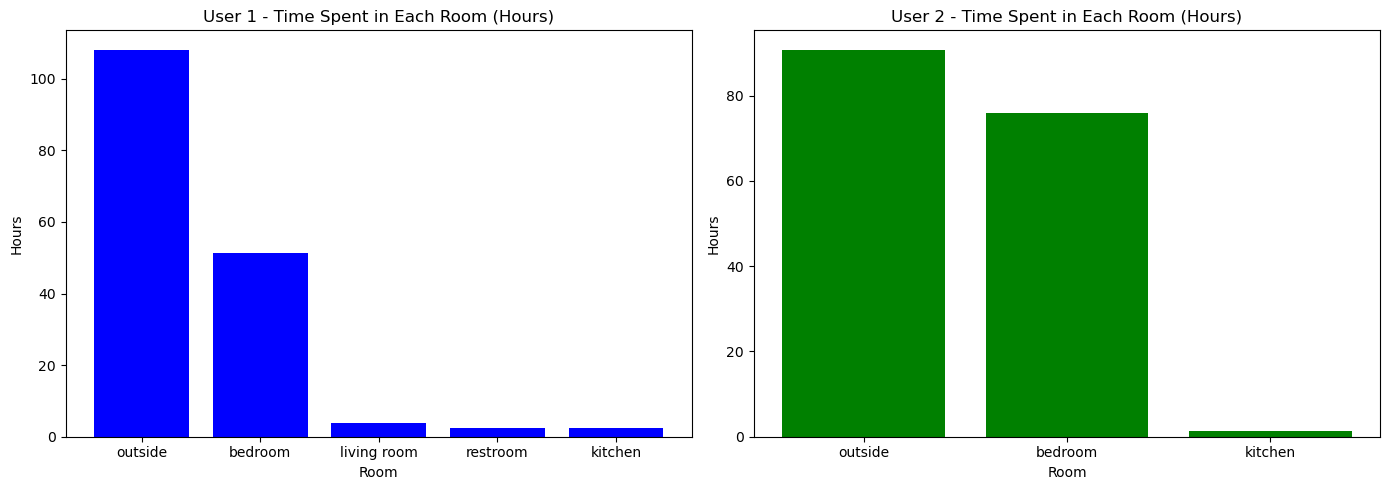

In [98]:
# Create bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar Chart - User 1
axes[0].bar(user1_hours.index, user1_hours.values, color='blue')
axes[0].set_title("User 1 - Time Spent in Each Room (Hours)")
axes[0].set_ylabel("Hours")
axes[0].set_xlabel("Room")

# Bar Chart - User 2
axes[1].bar(user2_hours.index, user2_hours.values, color='green')
axes[1].set_title("User 2 - Time Spent in Each Room (Hours)")
axes[1].set_ylabel("Hours")
axes[1].set_xlabel("Room")

# Adjust layout
plt.tight_layout()
plt.show()

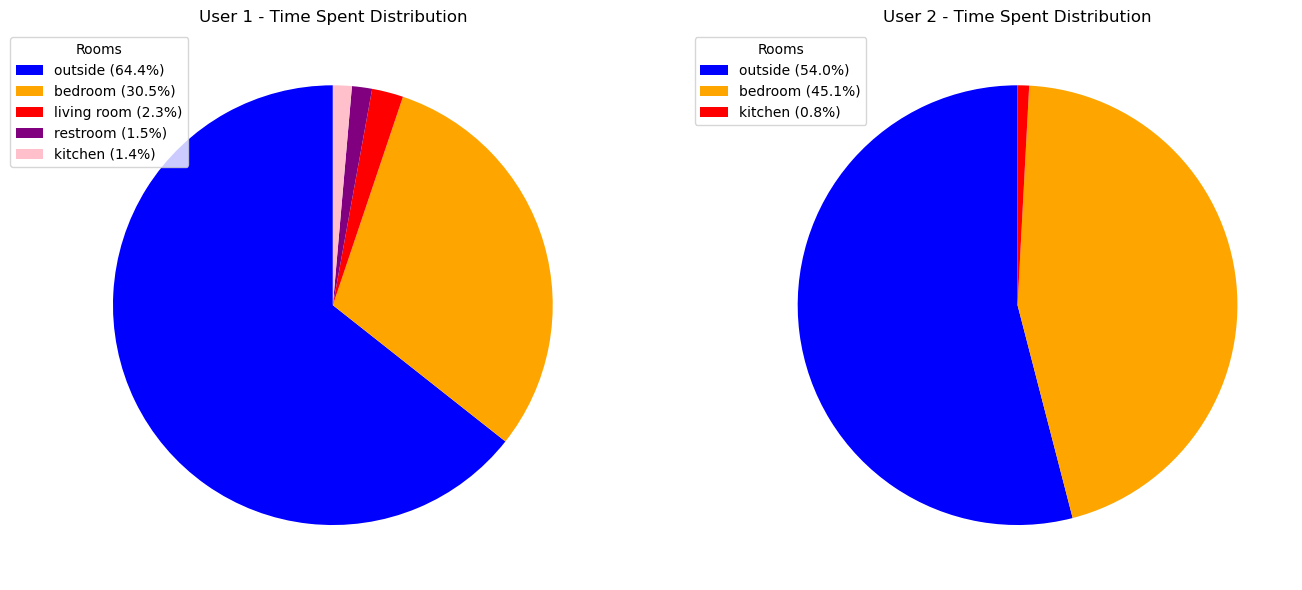

In [99]:
# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define consistent colors across both users
consistent_colors = ['blue', 'orange', 'red', 'purple', 'pink']  # Adjust based on actual room categories

# User 1 Pie Chart
wedges1, _ = axes[0].pie(user1_hours, labels=None, startangle=90, colors=consistent_colors)

# Add Legend in Top Left with Percentage
legend_labels1 = [f"{label} ({value:.1f}%)" for label, value in zip(user1_hours.index, user1_hours / user1_hours.sum() * 100)]
axes[0].legend(wedges1, legend_labels1, title="Rooms", loc="upper left", bbox_to_anchor=(-0.1, 1))
axes[0].set_title("User 1 - Time Spent Distribution")

# User 2 Pie Chart
wedges2, _ = axes[1].pie(user2_hours, labels=None, startangle=90, colors=consistent_colors)

# Add Legend in Top Left with Percentage
legend_labels2 = [f"{label} ({value:.1f}%)" for label, value in zip(user2_hours.index, user2_hours / user2_hours.sum() * 100)]
axes[1].legend(wedges2, legend_labels2, title="Rooms", loc="upper left", bbox_to_anchor=(-0.1, 1))
axes[1].set_title("User 2 - Time Spent Distribution")

# Adjust Layout
plt.tight_layout()
plt.show()

In [100]:
def get_longest_activity(df, user_col, target_state, activity_name):
    results = []
    
    for day in days:
        day_df = df[df["Day"] == day]

        # Identify where the target state occurs
        state_mask = day_df[user_col] == target_state
        streaks = state_mask.astype(int).groupby(state_mask.ne(state_mask.shift()).cumsum()).cumsum()

        max_streak = streaks.max() if not streaks.empty else 0  # Only keep the longest streak

        results.append({
            "Day": day,
            f"Longest {activity_name} (steps)": max_streak
        })
    
    return pd.DataFrame(results)

In [101]:
def convert_steps_to_time(df, longest_col):
    def format_time(steps):
        # If already in HH:MM:SS format, return as is
        if isinstance(steps, str) and ":" in steps:
            return steps
        
        # Convert numerical step count to HH:MM:SS
        steps = int(steps)  # Ensure integer conversion
        total_seconds = steps * 30
        hours = int(total_seconds // 3600)  # Convert to integer
        minutes = (total_seconds % 3600) // 60
        seconds = total_seconds % 60

        return f"{hours:02}:{minutes:02}:{seconds:02}", total_seconds / 3600  # Return formatted time + float hours

    # Apply conversion
    converted = df[longest_col].apply(format_time)
    
    # Unpack into two new columns
    df[longest_col] = converted.apply(lambda x: x[0])  # HH:MM:SS formatted
    df[longest_col.replace("steps", "hours")] = converted.apply(lambda x: x[1])  # Numeric hours

    return df


In [102]:
# Compute Longest Bedroom & Outside Activities (No Shortest)
longest_bedroom_user1 = get_longest_activity(predictions_df, "User1_State", "bedroom", "Bedroom Activity (User1)")
longest_bedroom_user2 = get_longest_activity(predictions_df, "User2_State", "bedroom", "Bedroom Activity (User2)")

longest_outside_user1 = get_longest_activity(predictions_df, "User1_State", "outside", "Outside Activity (User1)")
longest_outside_user2 = get_longest_activity(predictions_df, "User2_State", "outside", "Outside Activity (User2)")

# Convert Steps to HH:MM:SS Format and Add Numeric Hours Column
longest_bedroom_user1 = convert_steps_to_time(longest_bedroom_user1, "Longest Bedroom Activity (User1) (steps)")
longest_bedroom_user2 = convert_steps_to_time(longest_bedroom_user2, "Longest Bedroom Activity (User2) (steps)")

longest_outside_user1 = convert_steps_to_time(longest_outside_user1, "Longest Outside Activity (User1) (steps)")
longest_outside_user2 = convert_steps_to_time(longest_outside_user2, "Longest Outside Activity (User2) (steps)")


In [103]:
longest_bedroom_user1.head()

,Day,Longest Bedroom Activity (User1) (steps),Longest Bedroom Activity (User1) (hours)
0,Monday,04:14:30,4.241667
1,Tuesday,04:10:30,4.175000
2,Wednesday,04:17:00,4.283333
3,Thursday,03:34:00,3.566667
4,Friday,02:45:30,2.758333


In [104]:
longest_bedroom_user2.head()

,Day,Longest Bedroom Activity (User2) (steps),Longest Bedroom Activity (User2) (hours)
0,Monday,07:52:00,7.866667
1,Tuesday,08:36:30,8.608333
2,Wednesday,07:44:30,7.741667
3,Thursday,06:42:00,6.700000
4,Friday,06:36:30,6.608333


In [105]:
longest_outside_user1.head()

,Day,Longest Outside Activity (User1) (steps),Longest Outside Activity (User1) (hours)
0,Monday,09:16:30,9.275000
1,Tuesday,09:24:30,9.408333
2,Wednesday,09:36:00,9.600000
3,Thursday,10:33:00,10.550000
4,Friday,09:23:00,9.383333


In [106]:
longest_outside_user2.head()

,Day,Longest Outside Activity (User2) (steps),Longest Outside Activity (User2) (hours)
0,Monday,10:23:00,10.383333
1,Tuesday,05:13:30,5.225000
2,Wednesday,06:13:00,6.216667
3,Thursday,13:45:00,13.750000
4,Friday,16:02:30,16.041667


C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\2074339978.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(longest_bedroom_user1["Day"], rotation=45)
C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\2074339978.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(longest_bedroom_user2["Day"], rotation=45)
C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\2074339978.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(longest_outside_user1["Day"], rotation=45)
C:\Users\hanzj\AppData\Local\Temp\ipykernel_15476\2074339978.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

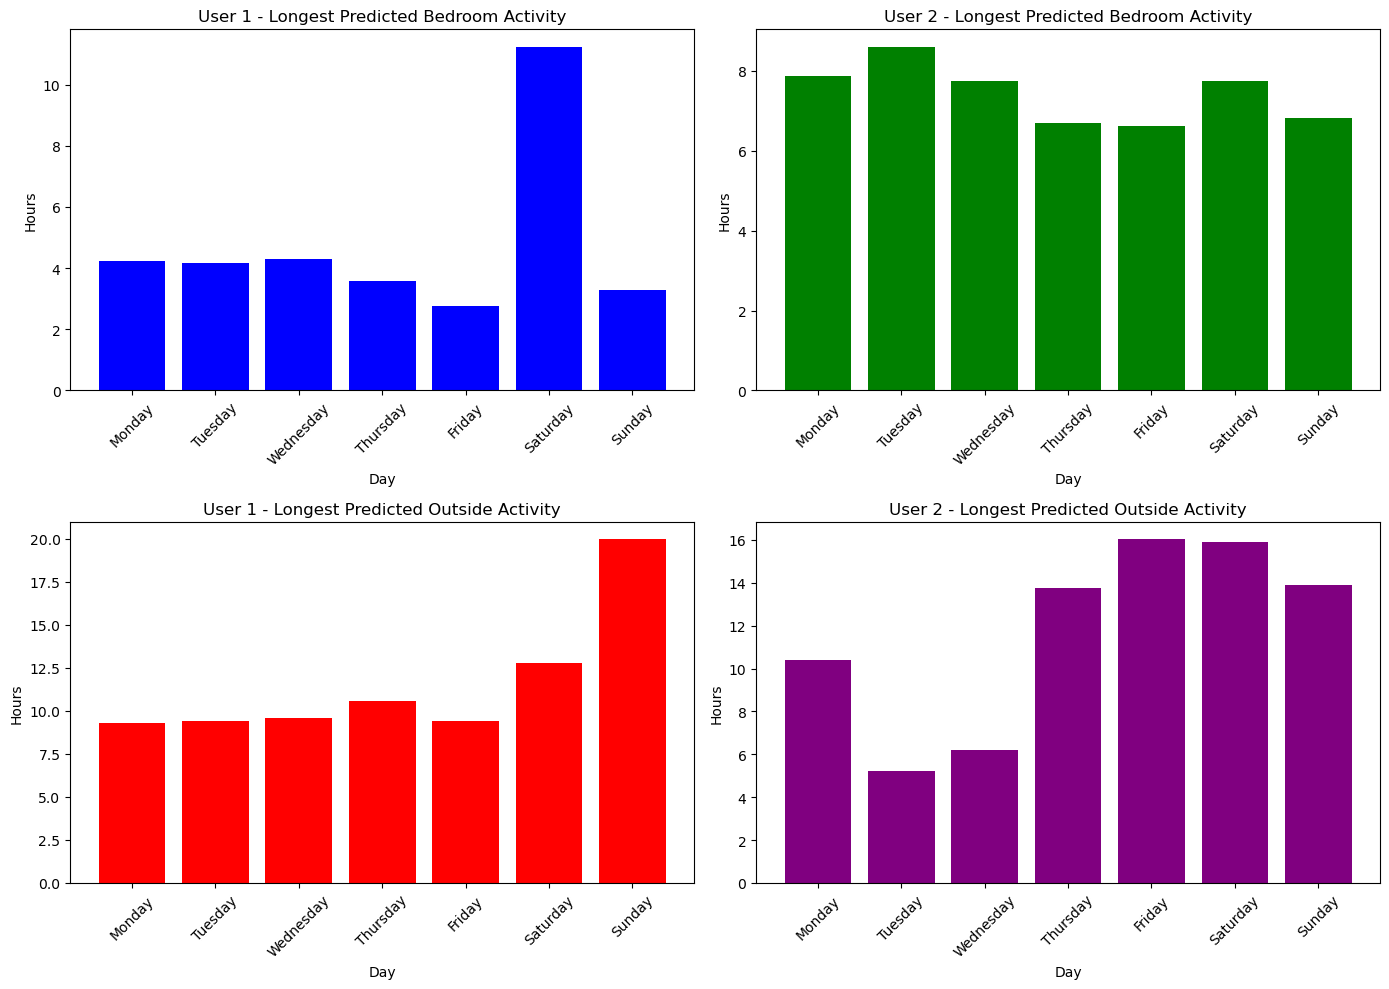

In [107]:
# Create plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Bedroom Activity - User 1
axes[0, 0].bar(longest_bedroom_user1["Day"], longest_bedroom_user1["Longest Bedroom Activity (User1) (hours)"], color='blue')
axes[0, 0].set_title("User 1 - Longest Predicted Bedroom Activity")
axes[0, 0].set_ylabel("Hours")
axes[0, 0].set_xlabel("Day")
axes[0, 0].set_xticklabels(longest_bedroom_user1["Day"], rotation=45)

# Plot Bedroom Activity - User 2
axes[0, 1].bar(longest_bedroom_user2["Day"], longest_bedroom_user2["Longest Bedroom Activity (User2) (hours)"], color='green')
axes[0, 1].set_title("User 2 - Longest Predicted Bedroom Activity")
axes[0, 1].set_ylabel("Hours")
axes[0, 1].set_xlabel("Day")
axes[0, 1].set_xticklabels(longest_bedroom_user2["Day"], rotation=45)

# Plot Outside Activity - User 1
axes[1, 0].bar(longest_outside_user1["Day"], longest_outside_user1["Longest Outside Activity (User1) (hours)"], color='red')
axes[1, 0].set_title("User 1 - Longest Predicted Outside Activity")
axes[1, 0].set_ylabel("Hours")
axes[1, 0].set_xlabel("Day")
axes[1, 0].set_xticklabels(longest_outside_user1["Day"], rotation=45)

# Plot Outside Activity - User 2
axes[1, 1].bar(longest_outside_user2["Day"], longest_outside_user2["Longest Outside Activity (User2) (hours)"], color='purple')
axes[1, 1].set_title("User 2 - Longest Predicted Outside Activity")
axes[1, 1].set_ylabel("Hours")
axes[1, 1].set_xlabel("Day")
axes[1, 1].set_xticklabels(longest_outside_user2["Day"], rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


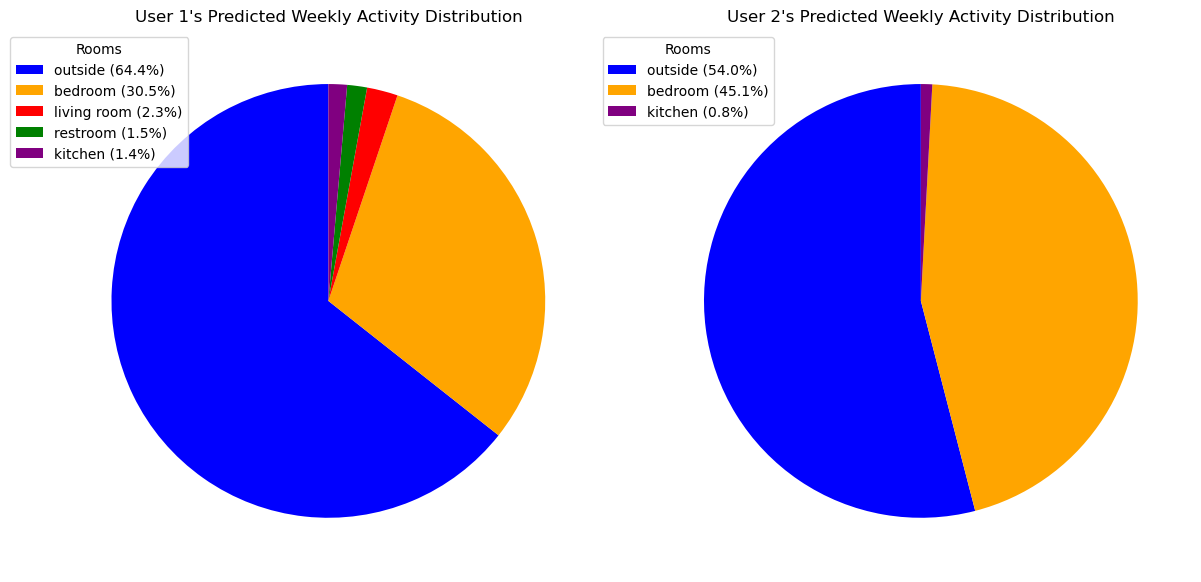

In [108]:
# Define fixed color mapping for all rooms
color_mapping = {
    "outside": "blue",
    "bedroom": "orange",
    "living room": "red",
    "restroom": "green",
    "kitchen": "purple"
}

# Convert categorical indexes to ordered lists for consistent color assignment
user1_labels = user1_hours.index.tolist()
user2_labels = user2_hours.index.tolist()

# Assign colors based on the defined mapping
user1_colors = [color_mapping[label] for label in user1_labels]
user2_colors = [color_mapping[label] for label in user2_labels]

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# User 1 Pie Chart (No Labels Inside, Consistent Colors)
wedges1, _ = axes[0].pie(user1_hours, labels=None, startangle=90, colors=user1_colors)
legend_labels1 = [f"{label} ({value:.1f}%)" for label, value in zip(user1_labels, user1_hours / user1_hours.sum() * 100)]
axes[0].legend(wedges1, legend_labels1, title="Rooms", loc="upper left", bbox_to_anchor=(-0.1, 1))
axes[0].set_title("User 1's Predicted Weekly Activity Distribution")

# User 2 Pie Chart (No Labels Inside, Consistent Colors)
wedges2, _ = axes[1].pie(user2_hours, labels=None, startangle=90, colors=user2_colors)
legend_labels2 = [f"{label} ({value:.1f}%)" for label, value in zip(user2_labels, user2_hours / user2_hours.sum() * 100)]
axes[1].legend(wedges2, legend_labels2, title="Rooms", loc="upper left", bbox_to_anchor=(-0.1, 1))
axes[1].set_title("User 2's Predicted Weekly Activity Distribution")

# Adjust layout
plt.tight_layout()
plt.show()
